In [10]:
# 📌 Step 1: Install & Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import pickle
import warnings
warnings.filterwarnings("ignore")


In [12]:
# Load dataset
df = pd.read_csv("/kaggle/input/thyroid-cancer-detection/dataset.csv")
df.head()

,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


In [13]:
# 📌 Step 3: Basic Cleaning
df.drop_duplicates(inplace=True)
df.dropna(axis=1, how='all', inplace=True)  # remove any fully empty columns

# Print columns for reference
print(df.columns)


Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')


In [14]:
# 📌 Step 4: Encode Categorical Features
label_encoders = {}
df_encoded = df.copy()

for col in df_encoded.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le

# Save encoders + feature names for later prediction
with open('/kaggle/working/thyroid_model.pkl', 'wb') as f:
    pickle.dump((label_encoders, df_encoded.drop('Recurred', axis=1).columns.tolist()), f)


In [15]:
# 📌 Step 5: Train-Test Split
X = df_encoded.drop('Recurred', axis=1)
y = df_encoded['Recurred']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# 📌 Step 6: Train Model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Save model
with open('/kaggle/working/model_only.pkl', 'wb') as f:
    pickle.dump(model, f)


✅ Accuracy: 0.958904109589041

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        51
           1       0.95      0.91      0.93        22

    accuracy                           0.96        73
   macro avg       0.96      0.94      0.95        73
weighted avg       0.96      0.96      0.96        73



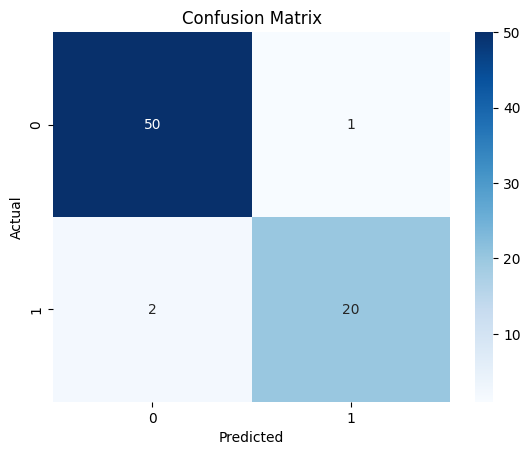

In [17]:
# 📌 Step 7: Evaluation
y_pred = model.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [18]:
# Load model and encoders
import pickle

with open('/kaggle/working/thyroid_model.pkl', 'rb') as f:
    label_encoders, feature_cols = pickle.load(f)

with open('/kaggle/working/model_only.pkl', 'rb') as f:
    model = pickle.load(f)

# Sample input
sample_patient = pd.DataFrame([{
    'Age': 47,
    'Gender': 'F',
    'Smoking': 'No',
    'HxRadiotherapy': 'No',
    'Thyroid Function': 'Normal',
    'Physical Examination': 'Normal',
    'Adenopathy': 'No',
    'Pathology': 'PTC',
    'Focality': 'Unifocal',
    'Risk': 'Low',
    'T': 'T1',
    'N': 'N0',
    'M': 'M0',
    'Stage': 'I',
    'Response': 'Excellent'
}])

# Encode & handle unknowns
for col in sample_patient.columns:
    if col in label_encoders:
        if sample_patient[col].values[0] in label_encoders[col].classes_:
            sample_patient[col] = label_encoders[col].transform(sample_patient[col])
        else:
            sample_patient[col] = -1  # unknown fallback
    else:
        sample_patient[col] = 0

# Add missing columns if any
for col in feature_cols:
    if col not in sample_patient.columns:
        sample_patient[col] = 0

sample_patient = sample_patient[feature_cols]

# Predict
prediction = model.predict(sample_patient)
print("🔮 Cancer Reoccurred:", "Yes" if prediction[0] == 1 else "No")


🔮 Cancer Reoccurred: No
